In [ ]:
import numpy as np
from yaml import safe_load
import json
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import ICRS, get_sun, Longitude
from sunpy.coordinates.frames import Helioprojective

from helioschedule.get_local_noons import SolarTransiter
from helioschedule.schedule import DayScheduler

from matplotlib import pyplot as plt

In [ ]:
SIDEREAL_FACTOR = 1.0027379093604878  # 86400/((1.0*units.sday).to(units.s).value)

In [ ]:
conf = safe_load(open("John_MWA_Dwell_solo_2024.yaml"))
azel = {int(k): v for k, v in json.load(open(conf["files"]["pointings"])).items()}
print(conf['priority'])
print(conf['solarOffset'])

### Calculate local noon closest to reference time

In [ ]:
# The following class abstracts dealing with skyfield
transiter = SolarTransiter(lat_deg_n=conf["lat"],
                            lon_deg_e=conf["lon"],
                            elevation_m=conf["alt"])

# Note that I haven't calculated that this is the exact time that the CME crosses the meridian.
# As long as it is correct within an hour or so, this shouldn't actually matter, at least for
# this test
ref_time = Time(conf['refDate'])

# Calculate the local noon closest to (within +/- 12 hours of) ref_time
# NB still need to supply times  in skyfield type, but SolarTransiter
# has an attribute to make this easy.
local_noon = transiter.get_transit(transiter.ts.from_astropy(ref_time-12*u.hour),
                                   transiter.ts.from_astropy(ref_time+12*u.hour)).to_astropy().utc[0]
local_noon.isot, int(local_noon.gps)
                                

In [ ]:
for i in range(5, 9):
    ref_time = Time(conf['refDate'])+i*u.day

    # Calculate the local noon closest to (within +/- 12 hours of) ref_time
    # NB still need to supply times  in skyfield type, but SolarTransiter
    # has an attribute to make this easy.
    local_noon = transiter.get_transit(transiter.ts.from_astropy(ref_time-12*u.hour),
                                    transiter.ts.from_astropy(ref_time+12*u.hour)).to_astropy().utc[0]
    print(local_noon.isot, int(local_noon.gps))
                                    


### Get Sun coordinates and calculate HA and Decl. of fields based on location of Sun at reference time.

For scheduling purposes, the coordinates required for each target are the Hour Angle *relative to the Sun* and the Declination, both in Degrees.

Note that the code in `convert_coordinates.py` which does this is not particularly accurate or fast (in part because it dates from before `sunpy` was mature). But it is good enough to make updating it a low priority. 

Here we can use `sunpy` for much more readable code.  Note that `Tx` is west positive, whereas for the yaml file, we measure position angle as North through East.

In [ ]:
sun = get_sun(ref_time)
assert len(conf['priority'])==1, f"Only expecting one field to schedule, got {len(conf['priority'])}"
c = conf['priority'][0]
hpc = Helioprojective(Tx=-conf['fields'][c]['coordinates'][0]*u.deg*np.sin(np.radians(conf['fields'][c]['coordinates'][1])),
                        Ty=conf['fields'][c]['coordinates'][0]*u.deg*np.cos(np.radians(conf['fields'][c]['coordinates'][1])),
                        distance=1*u.Mpc,
                        obstime = ref_time,
                        observer='earth')
radec = hpc.transform_to(ICRS())
ha=Longitude(radec.ra - sun.ra, wrap_angle=180 * u.deg)
dec=radec.dec


In [ ]:
ha.deg, dec.deg

In [ ]:
ha.hour*3600

### Set up Scheduler object and schedule

In [ ]:
scheduler = DayScheduler(conf=conf)
scheduler.setup_day(ref_time_gps=local_noon.gps + ha.hour*3600 - 600)
scheduler.setup_obs(solar_noon_gps=local_noon.gps, ha=ha.deg, dec=dec.deg, dec_sun=sun.dec.deg, beam_chan=conf['fields'][c]['beam_chan'])

In [ ]:
all_obstimes = scheduler.all_obstimes
target_beam = scheduler.target_beam
sun_beam = scheduler.sun_beam
sun_filter = scheduler.sun_filter

In [ ]:
print(all_obstimes[0])
print(divmod(all_obstimes[0], 8))

In [ ]:
# sun_filter=True means good
idxs = np.nanargmax(np.where(sun_filter, target_beam, np.nan), axis=0)
az = np.array([azel[i][0] for i in idxs])
el = np.array([azel[i][1] for i in idxs])

In [ ]:
plt.figure()
plt.plot(np.arange(len(az))*8/3600., az)
plt.xlabel("hours since start")
plt.ylabel("azimuth/degrees")
plt.grid()
plt.figure()
plt.plot(np.arange(len(az))*8/3600., el)
plt.xlabel("hours since start")
plt.ylabel("elevation/degrees")
plt.grid()
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(np.radians(az), 90-el)
ax.set_rmax(90)
ax.set_title("Az and Zenith angle (note North is right)")

In [ ]:
print(f"{len(idxs)} slots")
print(f"{len(np.unique(idxs))} unique pointings")
print(np.sum(np.diff(idxs) != 0), "changes of pointing")

change_idxs = np.hstack(([0], np.where(np.diff(idxs) != 0)[0]))
print("change_indices", change_idxs)
obs_lengths = np.diff(np.hstack((change_idxs, len(idxs))))
print(obs_lengths)
print(obs_lengths*8)
for i in sorted(np.unique(np.diff(change_idxs))):
    print(f"{np.sum(np.diff(change_idxs)==i)} observations of length {i*8}s")

In [ ]:
change_idxs
np.hstack(([0], change_idxs))

## Divide into equally spaced 200s observations

In [ ]:
idxs_200 = idxs.reshape(-1, 25)
print(idxs_200.shape)
n_obs_200 = idxs_200.shape[0]
print(f"{np.sum(np.all(idxs_200==idxs_200[:, 0, None], axis=1))}/{n_obs_200} observations have the same optimal pointing for all 25 8-second blocks")
for i in range(n_obs_200):
    if np.all(idxs_200[i]==idxs_200[None, i, 0]):
        continue
    print(i, idxs_200[i])

### Visualising Observations

In [ ]:
print(idxs.shape)
print(target_beam.shape)
print(np.repeat(5, 4))
np.arange(5)

In [ ]:
idxs_200 = idxs.reshape(-1, 25)
sb_200 = sun_beam.reshape(197, -1, 25)
tb_200 = target_beam.reshape(197, -1, 25)
print(idxs_200.shape)
print(sb_200.shape)
print(tb_200.shape)
n_obs_200 = idxs_200.shape[0]
print(f"{np.sum(np.all(idxs_200==idxs_200[:, 0, None], axis=1))}/{n_obs_200} observations have the same optimal pointing for all 25 8-second blocks")
for i in range(n_obs_200):
    if np.all(idxs_200[i]==idxs_200[None, i, 0]):
        continue
    plt.figure()
    plt.semilogy()
    plt.title(i)
    plt.axhline(10 ** scheduler.conf["solarAttenuationCutoff"], ls=':', color='black')
    plt.scatter(np.arange(25), tb_200[idxs_200[i], np.repeat(i, 25), np.arange(25)], color='black', marker='+', label="target_beam")
    plt.scatter(np.arange(25), sb_200[idxs_200[i], np.repeat(i, 25), np.arange(25)], color='black', marker='o', label="sun_beam")
    for idx in np.unique(idxs_200[i]):
        plt.plot(np.arange(25), tb_200[idx, i, :], label=f"target {idx}")
        plt.plot(np.arange(25), sb_200[idx, i, :], label=f"sun    {idx}")
    plt.legend()

UnitConversionError: Can only apply 'subtract' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan).

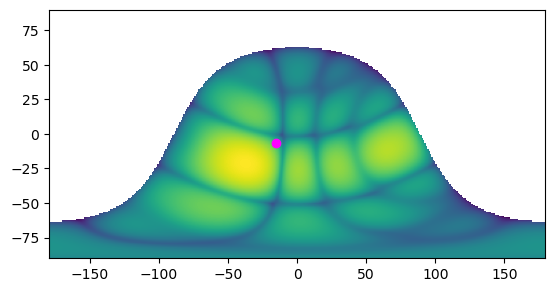

In [46]:
def mode(a):
    _, idx, counts = np.unique(a, return_index=True, return_counts=True)
    return a[idx[np.argmax(counts)]]

ha_scale =  scheduler.beams.df["beams"].dims[3][0]
dec_scale = scheduler.beams.df["beams"].dims[2][0]
for i in range(n_obs_200):
    freq_idx = scheduler.beams.beam_str_to_idx(conf["fields"][c]["beam_chan"])
    sweetspot=mode(idxs_200[i])
    beam_idx = np.where(scheduler.beams.df["beams"].dims[1][0]==sweetspot)[0][0]
    beam = scheduler.beams.df["beams"][freq_idx, beam_idx, ...]
    plt.figure()
    plt.imshow(np.log10(beam), origin='lower', extent=[ha_scale[0], ha_scale[-1], dec_scale[0], dec_scale[-1]])
    starttime = all_obstimes[i*25]
    sun_ha = 360*(starttime-local_noon.gps)/86400.
    plt.scatter([sun_ha], [sun.dec.deg], color='magenta', label='Sun')
    plt.scatter([sun_ha-ha.deg], [dec.deg], marker='+', color='magenta', label='Target')
    plt.title(f"{c} beam {sweetspot} ({np.unique(idxs_200[i])}) az={azel[sweetspot][0]:.0f} el={azel[sweetspot][1]:.0f}\n reftime{(starttime-ref_time.gps)/3600.:+.1f}hr solar noon{(starttime-local_noon.gps)/3600.:+.1f}hr" )
    plt.legend(loc='upper left')
    plt.savefig(f"all_plots/obs_{i:03d}.png")

In [ ]:
times = Time(all_obstimes[::25], format='gps')
(times.gps[-1]-times.gps[0])/3600.

# Generate Observing Script
May not be necessary if we are using triggering infrastructure?

In [ ]:
duration=200
obs_chan="57:68;121:132"
obs_name_prefix='waszewski2024a_ddt_ips'
field=""
shifttime=200
inttime=0.5
freqres=40
creator="jmorgan"
project="G0106"

In [ ]:
for i in range(n_obs_200):
    sweetspot=mode(idxs_200[i])
    az = azel[sweetspot][0]
    el = azel[sweetspot][1]
    time_comma = times[i].utc.isot[:19].replace("T", ",")
    obsid = str(int(times[i].gps))
    OBSERVATION_STR = f"schedule_observation.py --starttime={time_comma} --stoptime=++{duration}s --freq='{obs_chan}' --obsname={obs_name_prefix}{field} --shifttime={shifttime} --mode=MWAX_CORRELATOR --inttime={inttime} --freqres={freqres} --creator={creator} --project={project} --azimuth={az} --elevation={el} # {obsid}"
    print(OBSERVATION_STR)

In [ ]:
print("obsid,date,sweetspot,az,el,target_beam,sun_beam")
for i in range(n_obs_200):
    sweetspot=mode(idxs_200[i])
    az = azel[sweetspot][0]
    el = azel[sweetspot][1]
    time = times[i].utc.isot[:19]
    obsid = str(int(times[i].gps))
    target_beam = tb_200[sweetspot, i, 12]
    sun_beam = sb_200[sweetspot, i, 12]
    print(','.join((obsid,time,str(sweetspot),str(az),str(el),f"{target_beam:.6e}",f"{sun_beam:.6e}")))